## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

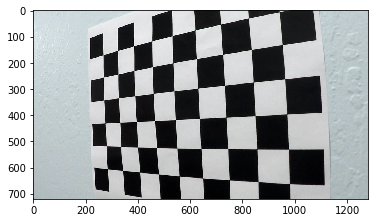

Points not found for img camera_cal/calibration4.jpg 


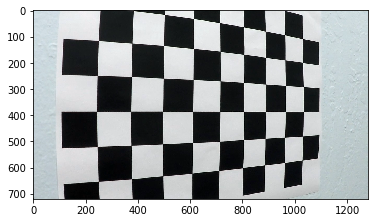

Points not found for img camera_cal/calibration5.jpg 


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images[1:]:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
    else:
        plt.imshow(img)
        plt.show()
        print ('Points not found for img %s ' % fname)

#cv2.destroyAllWindows()

## And so on and so forth...

In [2]:
ret, mtx, dist, rvecs, tvecs \
= cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)

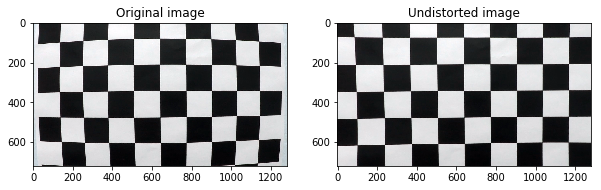

In [3]:
img=cv2.imread(images[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(10)

ax[0].imshow(img)
ax[0].set_title('Original image')

ax[1].imshow(dst)
ax[1].set_title('Undistorted image')

plt.savefig('images/distortion.png')

plt.show()

In [4]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [103]:
import glob

gl=glob.glob('test_images/*.jpg')

images=[mpl.image.imread(a) for a in gl]

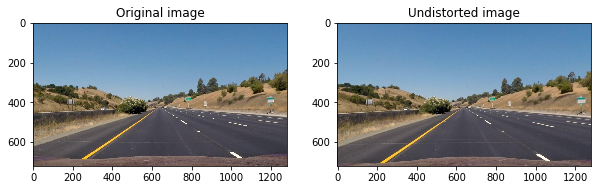

In [6]:
import matplotlib as mpl
img=mpl.image.imread('test_images/straight_lines1.jpg')
dst = undistort(img)

fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(10)

ax[0].imshow(img)
ax[0].set_title('Original image')

ax[1].imshow(dst)
ax[1].set_title('Undistorted image')

plt.savefig('images/undistorted_track.png')

plt.show()

# undistortion finished - going to perspective transformation

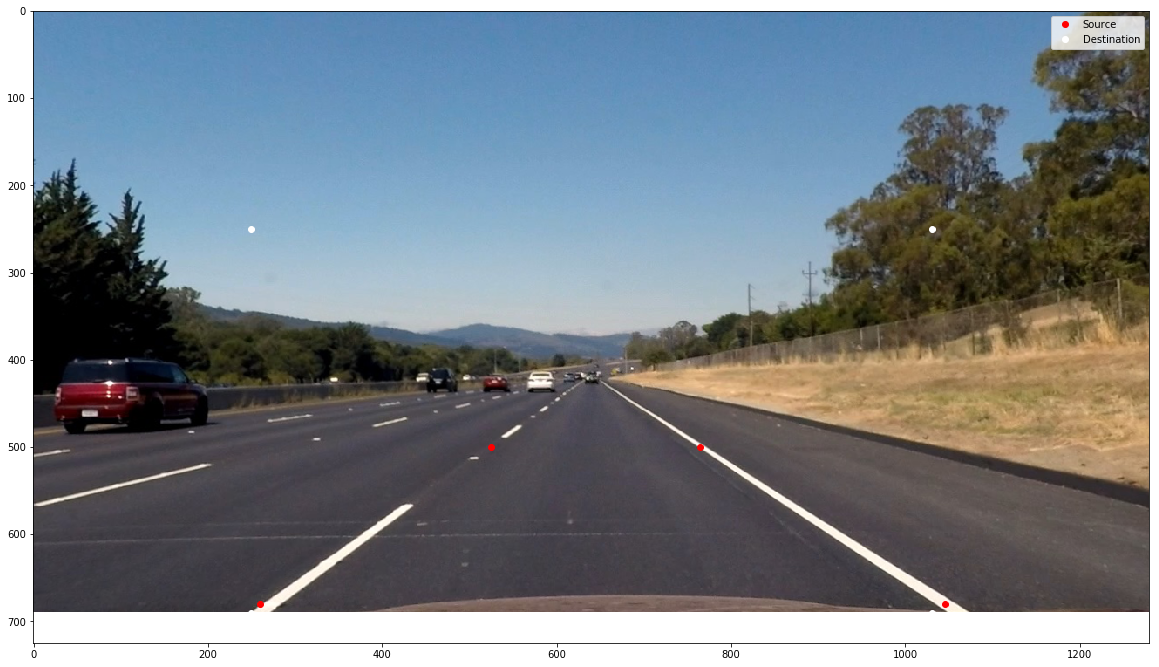

In [7]:
img=mpl.image.imread('test_images/straight_lines2.jpg')
img=undistort(img)

img=img[:690,:,:]

plt.figure(figsize=(20,20))
plt.imshow(img)


src=np.float32([[525,500],[img.shape[1]-515,500],[img.shape[1]-235,680],[260,680]])


offset=250

dst=np.float32([[offset,offset],[img.shape[1]-offset,offset],\
     [img.shape[1]-offset,img.shape[0]],[offset,img.shape[0]]])

plt.plot([a[0] for a in src],[a[1] for a in src],'ro',color='red',label='Source')
plt.plot([a[0] for a in dst],[a[1] for a in dst],'ro',color='white',label='Destination')

plt.legend()

plt.show()

In [8]:
#src=np.float32([[525,500],[img.shape[1]-515,500],[img.shape[1]-235,680],[260,680]])
#src=np.float32([[592+2,450],[690-2,450],[img.shape[1]-235,680],[270,680]])
src=np.float32([[525,500],[img.shape[1]-515,500],[img.shape[1]-235,680],[260,680]])
offset=250

dst=np.float32([[offset,offset],[img.shape[1]-offset,offset],\
     [img.shape[1]-offset,img.shape[0]],[offset,img.shape[0]]])

#dst=np.float32([[offset,offset],[img.shape[1]-offset,offset],\
#     [img.shape[1]-offset,img.shape[0]-offset],[offset,img.shape[0]-offset]])

M=cv2.getPerspectiveTransform(src,dst)
Minv=cv2.getPerspectiveTransform(dst,src)


def pr(img):
    return cv2.warpPerspective(img[:690],M, (img.shape[1],690), flags=cv2.INTER_LINEAR)

def pr_r(img):
    return cv2.warpPerspective(img,Minv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)



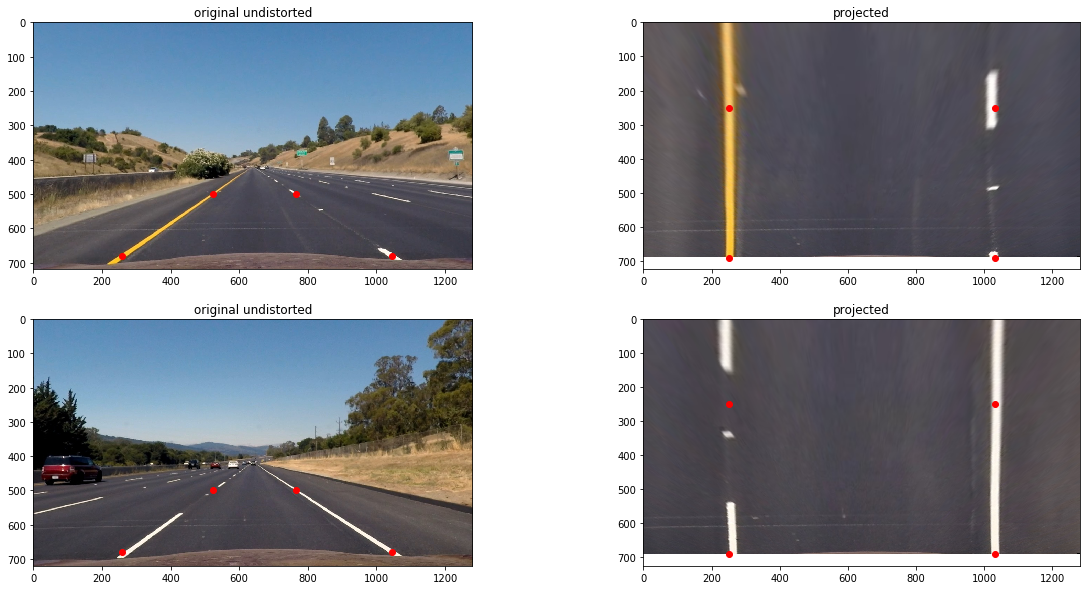

In [9]:
fig, ax = plt.subplots(2,2)

fig.set_figheight(10)
fig.set_figwidth(20)

for i,fname in enumerate(['./test_images/straight_lines1.jpg','./test_images/straight_lines2.jpg']):
    img=mpl.image.imread(fname)
    img=undistort(img)


    ax[i][0].imshow(img)
    ax[i][0].plot([a[0] for a in src],[a[1] for a in src],'ro',color='red')

    warped=pr(img)
    ax[i][1].imshow(warped)
    ax[i][1].plot([a[0] for a in dst],[a[1] for a in dst],'ro',color='red')
    
    ax[i][0].set_title('original undistorted')
    ax[i][1].set_title('projected')

plt.savefig('images/projected.png')
plt.show()

# finished with projection - going to detection of lines

In [10]:
#this functions taken from first project :)
def get_yellow_and_white(image, white=170, yellow_part=0.9):
    """Pickes yellow and white colors from image.
    We pick white color as color with all coordinates>=white
    We pick yellow  as all colors with red>150 and blue/green<0.9
    
    Of course our goal is to select most white and yellow and to get rid off most non white and non yellow colors
    """
    
    
    tmp=(cv2.inRange(image[:,:,0],150,255)  &\
    cv2.inRange(image[:,:,2]/image[:,:,1],0,yellow_part)) | \
    (cv2.inRange(image[:,:,0],white,255) \
    & cv2.inRange(image[:,:,1],white,255)\
    & cv2.inRange(image[:,:,2],white,255))
    
    tmp2=np.where(tmp==0)
    
    image1=image.copy()
    

    image1[tmp2]=[0,0,0]
    return image1


def get_channel(img,channel):
    """ 
    picks channel - avaliable channels are 'gray', 'h','l','s' and 'L','A','B'
    """
    if channel=='gray':
        res = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if channel in ('h','l','s'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if channel=='h':
            res = hls[:,:,0]
        elif channel=='l':
            res = hls[:,:,1] 
        else:
            res = hls[:,:,2]
    if channel in ('L','A','B'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        if  channel=='L':
            res = hls[:,:,0]
        elif channel=='A':
            res = hls[:,:,1] 
        else:
            res = hls[:,:,2]
    return res

def abs_sobel_thresh(img, orient='x', channel='gray',thresh=(0,255),\
                    sobel_kernel=5):
    """
    Absolute sobel threshold. Applyied to orientation, channel, threshhold
    """
    gray=get_channel(img,channel)
        
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255),channel='gray'):
    """
    Magniture threshold.
    """
    # Convert to grayscale
    gray=get_channel(img,channel)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return np.uint8(binary_output)

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2),channel='gray',normalize=False):
    """
    Direction threshold
    """
    gray=get_channel(img,channel)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return np.uint8(binary_output)

def channel_select(img, thresh=(0, 255), channel='gray', normalize=False):
    """
    Channel threshhold
    """
    gray=get_channel(img,channel)
    if normalize:
        gray = gray*(255/gray.max())
    binary_output = np.zeros_like(gray)
    binary_output[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return np.uint8(binary_output)


# I've tryed several approaches and finally created three functions. In most cases will be used "binarize_yellow", but the idea if lines not found to use other functions or other threshholds

In [11]:
def binarize(img, l_tresh=15, s_tresh=25):
    l_sobel = abs_sobel_thresh(img, channel='l',  thresh=(l_tresh,255))
    s_sobel = abs_sobel_thresh(img, channel='s',  thresh=(s_tresh,255))
    
    return s_sobel | l_sobel

def binarize_yellow(img, f=binarize, params={}):
    return f(get_yellow_and_white(img),**params)

def binarize_absl(img, s_thresh=120, sx_thresh=20,l_thresh=40):
    abss = abs_sobel_thresh(img, orient='x', channel='l',thresh=(sx_thresh,255))
    s=channel_select(img, channel='s', thresh=(s_thresh,255))
    l=channel_select(img, channel='l', thresh=(l_thresh,255))

    return (l*s)|abss



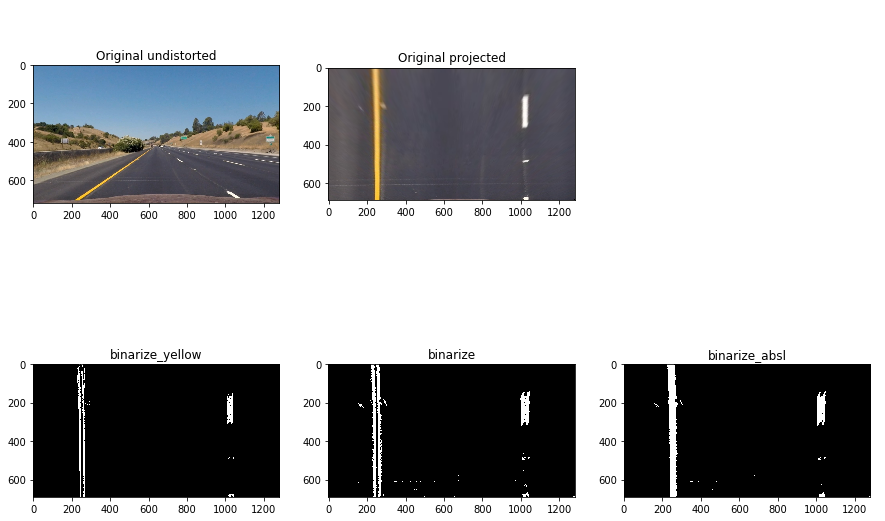

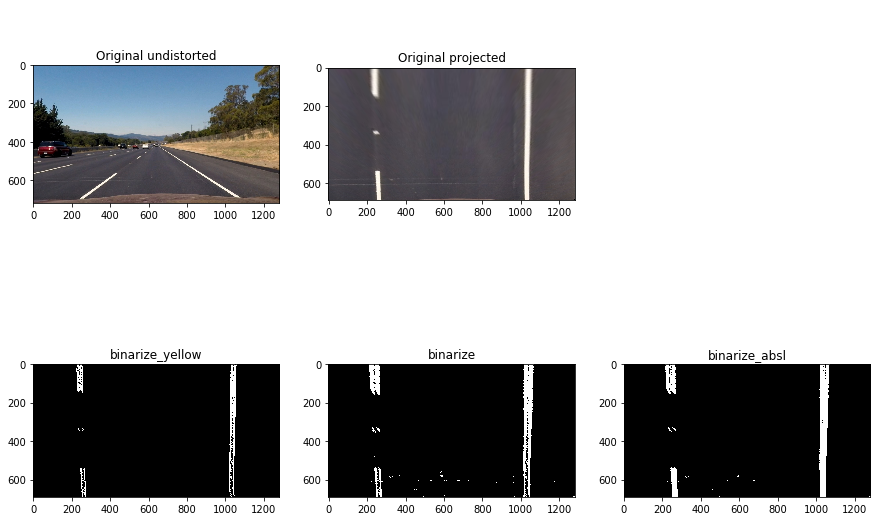

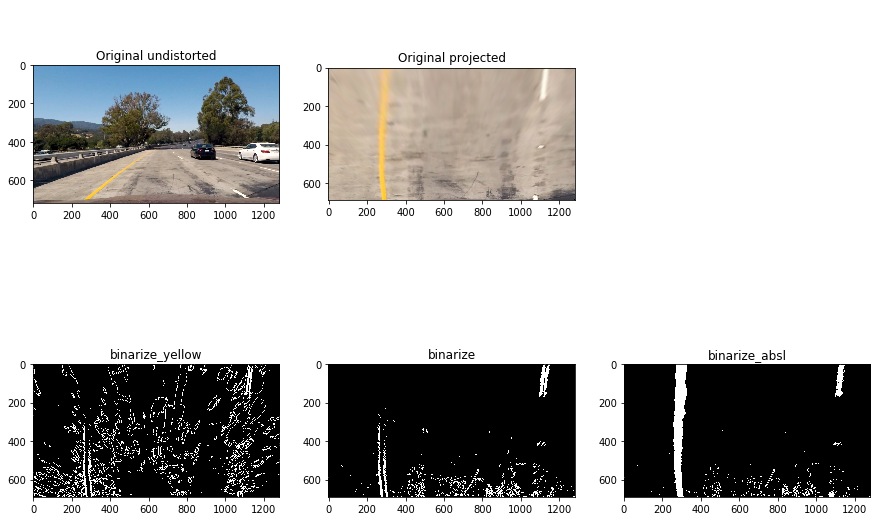

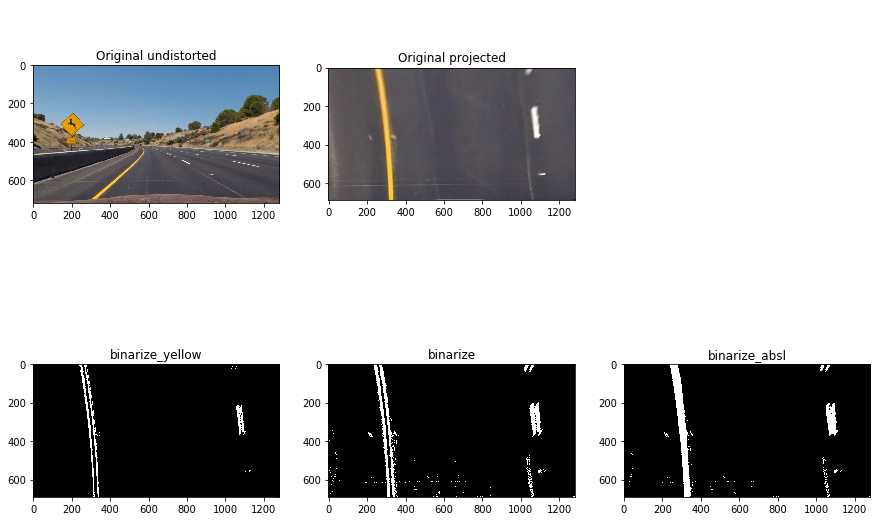

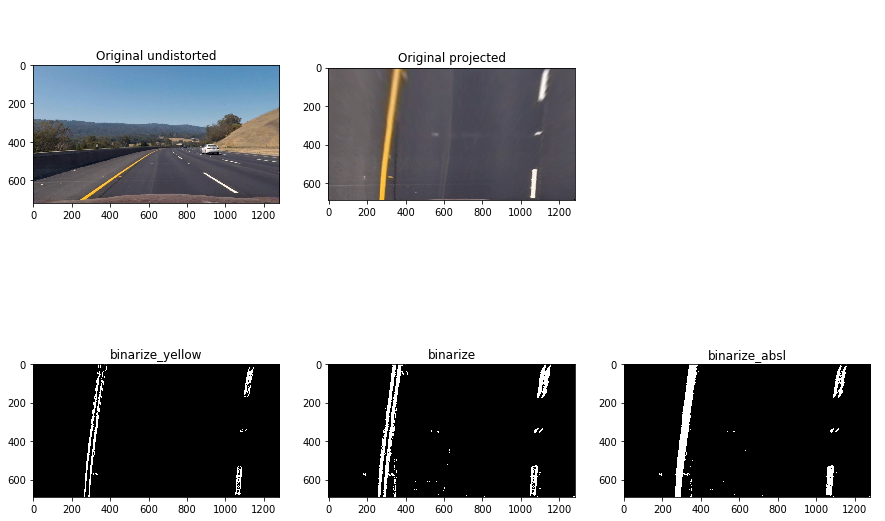

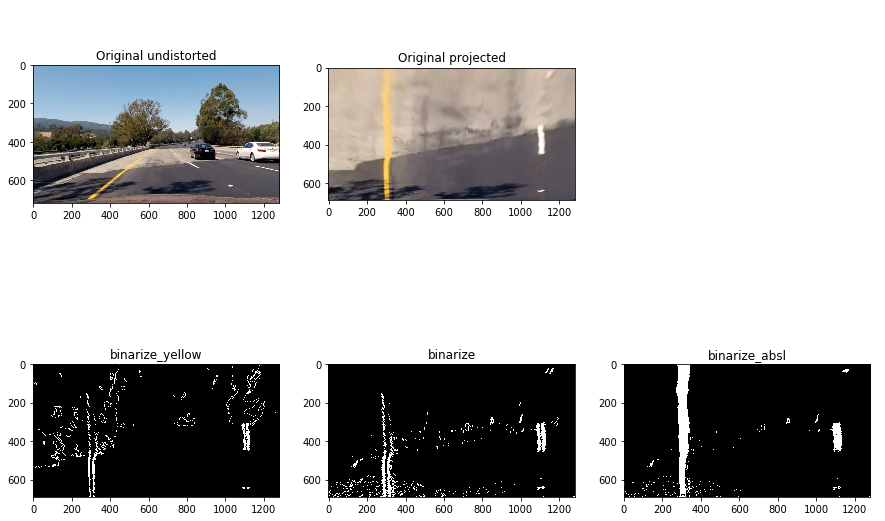

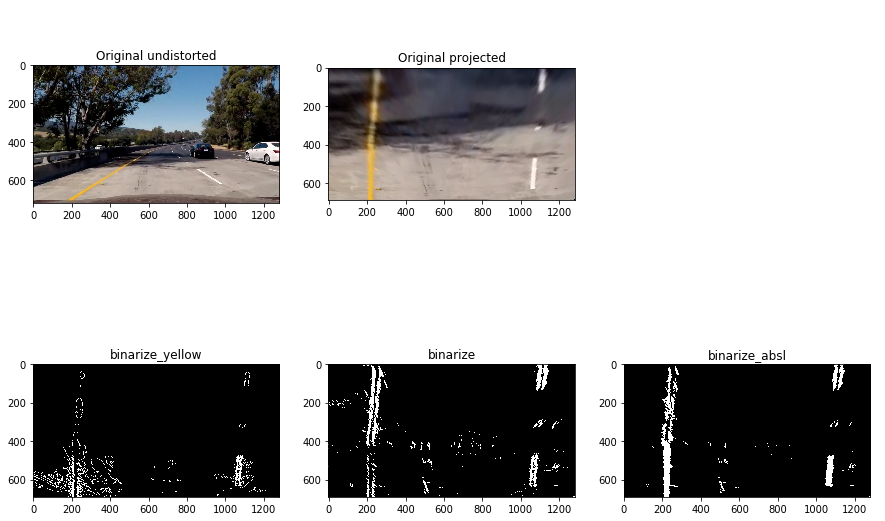

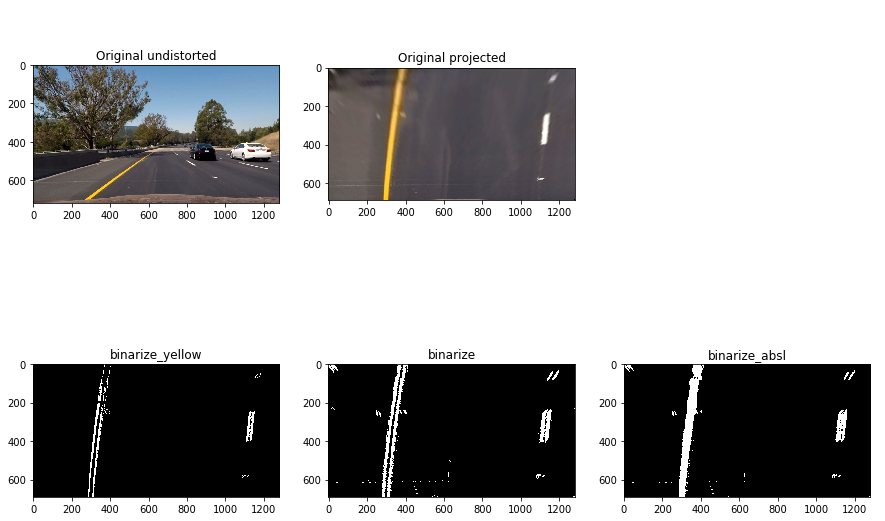

In [211]:
for i,img in enumerate(images):
    img=undistort(img)
    
    fig,ax=plt.subplots(2,3)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    ax[0][0].imshow(img)
    ax[0][1].imshow(pr(img))
    ax[0][2].set_axis_off()
    ax[1][0].imshow(binarize_yellow(pr(img)),cmap='gray')
    ax[1][1].imshow(binarize(pr(img)),cmap='gray')
    ax[1][2].imshow(binarize_absl(pr(img)),cmap='gray')
    
    ax[0][0].set_title('Original undistorted')
    ax[0][1].set_title('Original projected')
    ax[1][0].set_title('binarize_yellow')
    ax[1][1].set_title('binarize')
    ax[1][2].set_title('binarize_absl')
    
    plt.savefig('images/bin_%d.png' %i)
    plt.show()

# finished with binaryzing. Next: detecting lines. I've played a bit with convolving method, but used only sliding window for image recognizing

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


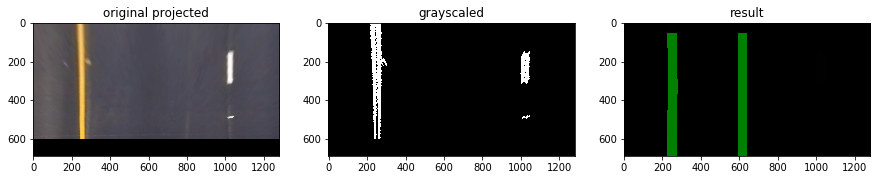

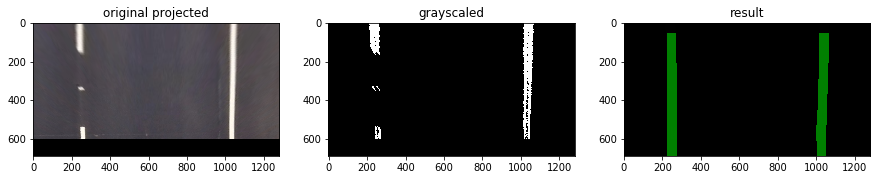

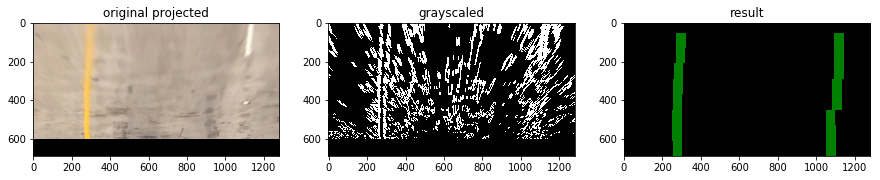

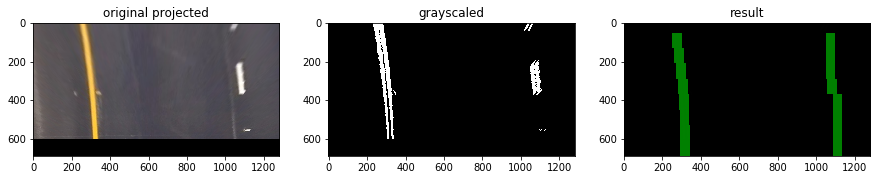

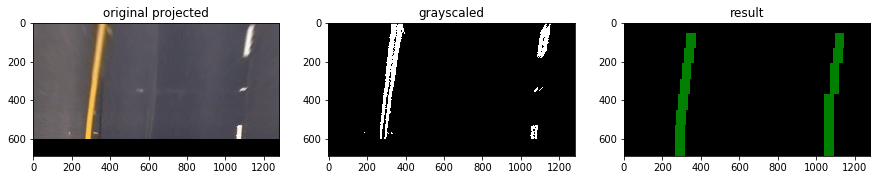

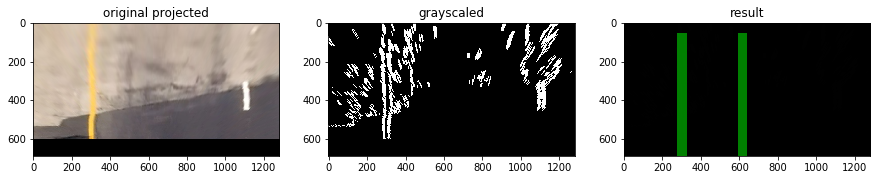

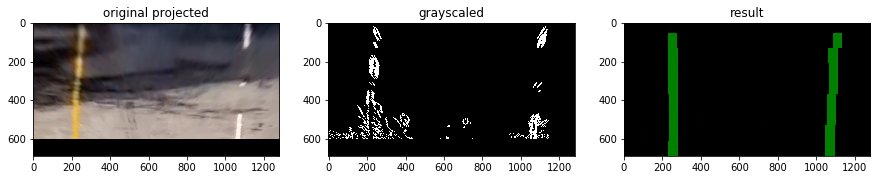

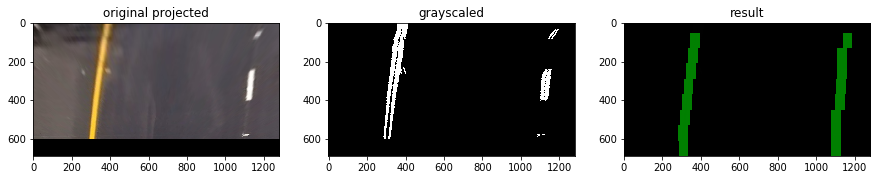

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
#warped = result
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin,\
                          margin_left=None,margin_right=None, max_tresh=0 ):
    """
    Added left and right margins
    """
    
    if not margin_left:
        margin_left, margin_right = margin,margin
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        #plt.plot (conv_signal)
        #plt.show()
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        
        if l_center>margin:
            l_min_index = int(max(l_center+offset-margin_left,0))
            l_max_index = int(min(l_center+offset+margin_right,warped.shape[1]))
            l_m=conv_signal[l_min_index:l_max_index].max()
            if l_m>max_tresh:
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        else:
            l_center=-margin

        # Find the best right centroid by using past right center as a reference
        if r_center>margin:
            r_min_index = int(max(r_center+offset-margin_left,0))
            r_max_index = int(min(r_center+offset+margin_right,warped.shape[1]))
            r_m=conv_signal[r_min_index:r_max_index].max()
            #print (r_m)
            if r_m>max_tresh:
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            
            
        else:
            r_center=warped.shape[1]+margin
        
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def draw_window_centroids(window_centroids):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output

for img in images:
    img=undistort(img)
    #plt.imshow(img)
    #plt.show()
    img=img[:600,:,:]
    warped=pr(binarize_yellow(img))
    
    window_centroids=find_window_centroids(img, window_width, window_height, margin)
    
    m=(np.array(window_centroids)[1:]-np.array(window_centroids)[:-1]).mean()
    
    if m>0:
        window_centroids=find_window_centroids(img, window_width, window_height, margin,\
                                           margin_left=1,margin_right=100)
    else:
        window_centroids=find_window_centroids(img, window_width, window_height, margin,\
                                           margin_left=100,margin_right=1, max_tresh=1000)
    
    output=draw_window_centroids(window_centroids)
    # Display the final results
    
    fig,ax=plt.subplots(1,3)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    ax[0].imshow(pr(img))
    ax[1].imshow(warped,cmap='gray')
    ax[2].imshow(output)
    ax[0].set_title('original projected')
    ax[1].set_title('grayscaled')
    ax[2].set_title('result')
    plt.show()




In [57]:
def fit_poly (binary_warped, verbose=False, fname=None):
    """
    Function binaty on image fits polynom using sliding windoes
    """

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom 1/4 of the image
    histogram = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    #leftx_base = np.argmax(histogram[:midpoint])
    #rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    leftx_base = np.argmax(histogram[100:450])+100
    rightx_base = np.argmax(histogram[1280-450:1280-100]) + 1280-450



    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #left and right centers
    left_centers=[]
    right_centers=[]

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            left_centers.append(leftx_current)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            right_centers.append(rightx_current)

    #get lines direction
    left_dir=np.array(right_centers)[:-1]-np.array(right_centers)[1:]
    right_dir=np.array(right_centers)[:-1]-np.array(right_centers)[1:]
    direction = np.concatenate([left_dir, right_dir]).mean()

    #if direction<-20:
    #    good_left=np.where(left_dir<0)[0]
    #    good_right=np.where(right_dir<0)[0]
    #elif direction>20:
    #    good_left=np.where(left_dir>0)[0]
    #    good_right=np.where(right_dir>0)[0]
    if True:
        good_left=range(len(left_dir)+1)
        good_right=range(len(right_dir)+1)
        
    t=50
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)#[left_lane_inds[a] for a in good_left\
                                   #if len(left_lane_inds[a])>t])
    right_lane_inds = np.concatenate(right_lane_inds)#[right_lane_inds[a]  for a in good_right\
                                    #if len(right_lane_inds[a])>t])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if verbose:
        fig,ax=plt.subplots(1,2)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        ax[0].imshow(out_img)

        ax[1].imshow(binary_warped,cmap='gray')
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)
        
        ax[0].set_title('Binaty image')
        ax[1].set_title('Lines detected')
        
        if fname:
            plt.savefig(fname)
        
        plt.show()
    return left_fit, right_fit, left_curverad, right_curverad

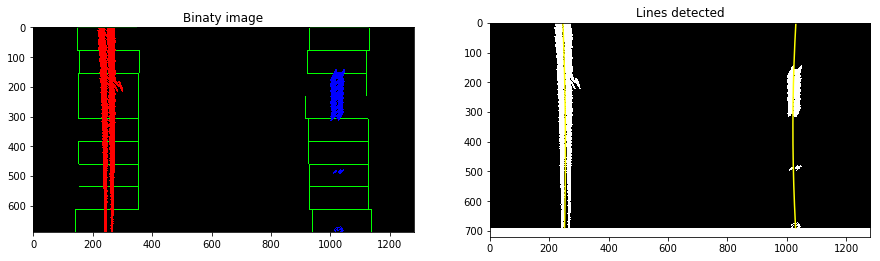

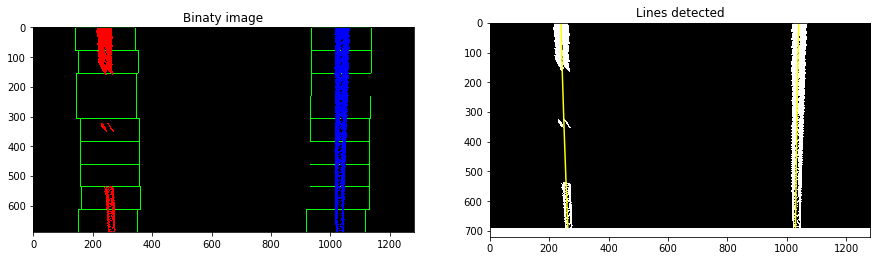

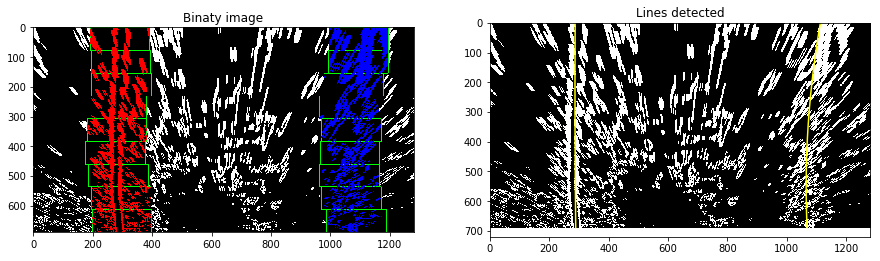

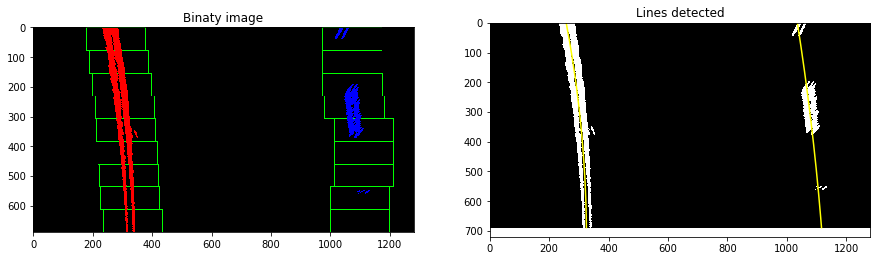

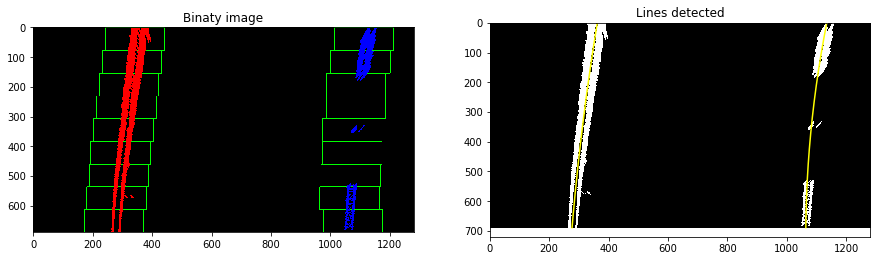

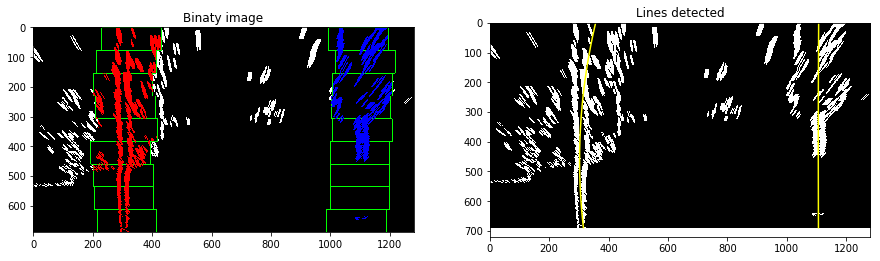

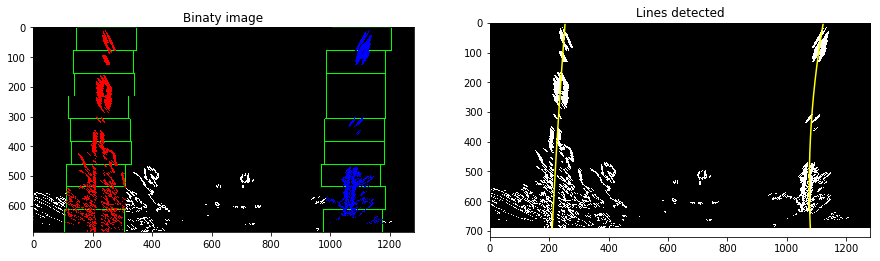

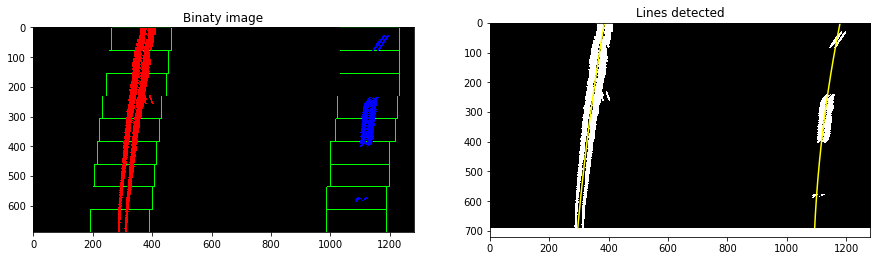

In [58]:
for i,img in enumerate(images):
    binary_warped = pr(binarize_yellow(undistort(img)))
    fit_poly(binary_warped,verbose=True,fname='images/lines_%d.png'%i)

# now let's visualize this on all test images

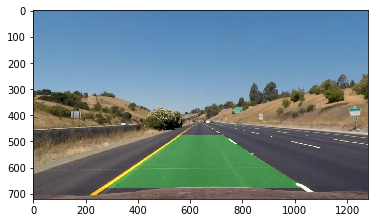

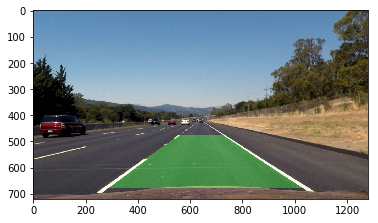

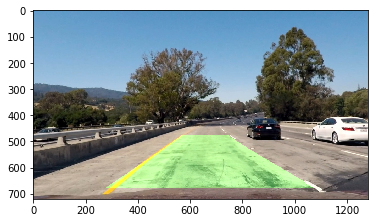

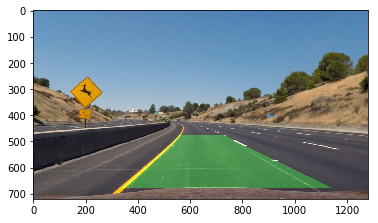

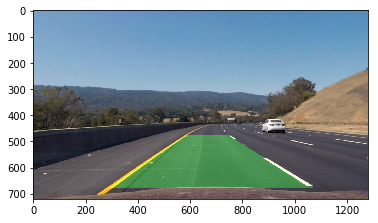

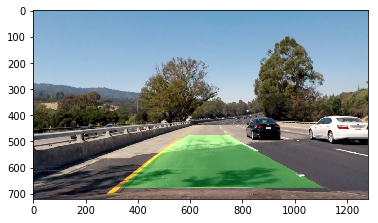

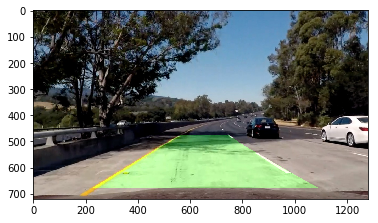

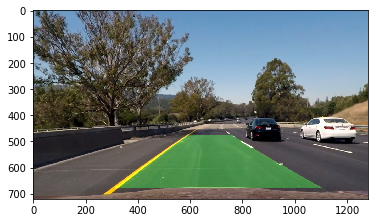

In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

for i,image in enumerate(images):
    
    image=undistort(image)
    binary_warped=(binarize_yellow(pr(image)))
    
    
    left_fit, right_fit, left_curverad, right_curverad = \
    fit_poly(binary_warped, verbose=False)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    plt.savefig('images/visualized_%d.png'%i)
    plt.show()

# this is class for video recognition. it uses several idias:
## all lines are checked in two ways: thay are parallel, enough far from each other and near parallel to previous line
## if lines could not be recognized with current binarization function it takes other binaryzation function
## if it do not helps just takes previous lines, but draw it with blue color
## if more than 5 images are not recognised - drawing the red one

In [205]:
from itertools import product


ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension



def max_sorted(q):
    tmp=[a for a in q]
    tmp_sum=[-sum(a) for a in tmp]
    return [tmp[i] for i in np.argsort(tmp_sum)]

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        self.recent_fitted=[]
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.errors=[]
        
        self.cnt_errors=0
        
        self.images=[]
        
        self.last_good=None
        self.radiuses=[]
        
        
        self.functions=\
        [(binarize_yellow,{})]+\
        [(binarize_yellow,{'f':binarize,'params':{'l_tresh':a[0],'s_tresh':a[1]}}) \
                   for a in max_sorted(product(range(5,50,5),range(5,50,5)))]+\
        [(binarize,{'l_tresh':a[0],'s_tresh':a[1]}) \
                   for a in max_sorted(product(range(5,50,5),range(5,50,5)))]+\
        [(binarize_absl,{'s_thresh':a[0],'l_thresh':a[1],'sx_thresh':a[2]}) \
                   for a in max_sorted(product(range(5,50,5),range(5,50,5),range(5,120,5)))]
        
        self.functions=\
        [(binarize_yellow,{}),\
         (binarize_absl,{'sx_thresh':40,'l_thresh':60}),\
         (binarize_absl,{}),\
         (binarize,{})]

       
    def visualise(self,image,binary_warped):
        left_fit, right_fit = self.best_fit
        
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw the lines on
        color_warp = np.zeros_like(image).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        
        color=(0,255,0) if self.detected else (0,0, 255)
        
        if self.cnt_errors>5:
            color=(255,0,0)
        
        cv2.fillPoly(color_warp, np.int_([pts]), color)
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        
        #looking for a distance from center of image
        tmp=np.array(self.best_fit)
        
        distance=xm_per_pix*\
            (np.mean(tmp[:,0]*690**2+tmp[:,1]*690+tmp[:,2])-image.shape[1]/2)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        result2=np.copy(result)
        #cv2.putText(result2,'Distance from center %d cm' % ,\
        #            (100,100), font, 2,(255,255,255),10)
        cv2.putText(result2,'Distance from center %d cm' % (distance*100),\
                    (100,200), font, 2,(255,255,255),10)
        
        
        cv2.putText(result2,'Radius of curvation %.2f km' % (np.mean(self.radiuses[-10:])/1000),\
                    (100,100), font, 2,(255,255,255),10)

        return result2
    
    def check_lines(self,lines):
        """
        Checking that lines are almost parallel and distance between them is big
        """
        self.detected=False
        
        #checking that lines are parallel
        #better to ckeck curvation :)
        div=np.abs(lines[0]-lines[1])
        if div[0]<0.0005 and div[1]<0.7:
            self.detected=True
            
        #checking that lines are paralleil to previous fit
            
        #check that bottom of the lines are somewhere where we are looking for them
        tmp=np.array(lines)
        l,r=tmp[:,0]*690**2+tmp[:,1]*690+tmp[:,2]
        
        if l>450 or l<100 or r>1280-100 or r<1280-450:
            self.detected=False
            
        return self.detected
            
    def find_by_poly(self,binary_warped,left_fit, right_fit):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        return left_fit, right_fit, left_curverad,  right_curverad
        
    def process_img(self, img, verbose=False, binarize=binarize):
        self.images.append(img)
        image=undistort(img)
        prj=pr(image)
        
        self.detected=False
        
        
        
        for f,params in self.functions:
            #binary_warped = (binarize(pr(image)))
            binary_warped=f(prj,**params)
            check=False
            #if not fitted or too many erors
            if not self.best_fit or self.cnt_errors>5:
                #tying to make new fit
                try:
                    left_fit, right_fit, left_curverad, right_curverad\
                    = fit_poly(binary_warped, verbose=verbose)
                    self.recent_fitted=[]
                    check=self.check_lines((left_fit,right_fit))
                #can not make new fit - oops, going back to the last one
                #we will have red visualisation
                except:
                    left_fit, right_fit= self.best_fit
            else:  
                left_fit, right_fit= self.best_fit

            #if not checked yet trying normal process - when we already have fitted lines
            if not check:
                #notmal process
                try:
                    left_fit, right_fit,left_curverad,  right_curverad = self.find_by_poly(binary_warped,left_fit, right_fit)
                    check=self.check_lines((left_fit,right_fit))
                #somthing got wrong
                except:
                    #trying using inital process
                    try:
                        left_fit, right_fit, left_curverad,  right_curverad\
                            = fit_poly(binary_warped, verbose=verbose)
                        check=self.check_lines((left_fit,right_fit))
                    #ok, we are not lucky - maybe with the next function?
                    except:
                        check=False
                    
            if check:
                break
                
        self.detected=check
        #if out iterative process did not giv a result - taking the last one
        
        if not check:
            if self.best_fit:
                left_fit, right_fit= self.best_fit
            self.errors.append((img,(left_fit, right_fit),self.best_fit))
            self.cnt_errors+=1
       
        #if fit is ok than save it and best fit is an average
        if check:
            #write curvation radius
            if not self.radius_of_curvature or (left_curverad-right_curverad)<0.01:
                self.radius_of_curvature=np.mean([left_curverad,right_curverad])
            else:
                if np.abs(self.radius_of_curvature-left_curverad)>\
                    np.abs(self.radius_of_curvature-right_curverad):
                    self.radius_of_curvature=right_curverad
                else:
                    self.radius_of_curvature=left_curverad
                    
            self.radiuses.append(self.radius_of_curvature)
                    
            
            self.cnt_errors=0
            self.recent_fitted.append((left_fit, right_fit))
            
            self.best_fit = (np.mean([a[0] for a in l.recent_fitted[-5:]],axis=0),\
                             np.mean([a[1] for a in l.recent_fitted[-5:]],axis=0))
        elif self.cnt_errors>5:
            #if too many errors - best is the last, clear history
            self.recent_fitted=[]
            self.recent_fitted.append((left_fit, right_fit))
            self.best_fit = (left_fit, right_fit)
        else:
            #else just keep the last one
            if not self.best_fit:
                self.best_fit = (left_fit, right_fit)
        
        return self.visualise(image, binary_warped)
        

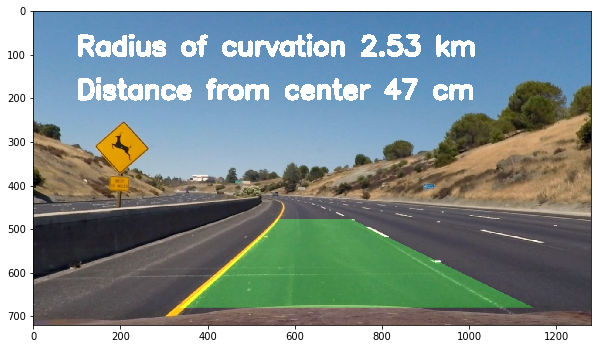

In [155]:
img=images[3]

l=Line()
plt.figure(figsize=(10,10))
plt.imshow(l.process_img(img))
plt.show()

In [157]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

for videofile in ('challenge_video.mp4','project_video.mp4','harder_challenge_video.mp4'):
    l=Line()
    clip1 = VideoFileClip(videofile)
    white_clip = clip1.fl_image(l.process_img) #NOTE: this function expects color images!!
    white_clip.write_videofile(videofile.replace('video','anotated'), audio=False)



[MoviePy] >>>> Building video challenge_anotated.mp4
[MoviePy] Writing video challenge_anotated.mp4


100%|██████████| 485/485 [01:41<00:00,  5.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_anotated.mp4 

[MoviePy] >>>> Building video project_anotated.mp4
[MoviePy] Writing video project_anotated.mp4


100%|█████████▉| 1260/1261 [04:31<00:00,  4.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_anotated.mp4 

[MoviePy] >>>> Building video harder_challenge_anotated.mp4
[MoviePy] Writing video harder_challenge_anotated.mp4


100%|█████████▉| 1199/1200 [05:56<00:00,  3.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_anotated.mp4 



In [206]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

for videofile in ['harder_challenge_video.mp4']:
    l=Line()
    clip1 = VideoFileClip(videofile)
    white_clip = clip1.fl_image(l.process_img) #NOTE: this function expects color images!!
    white_clip.write_videofile(videofile.replace('video','anotated'), audio=False)




[MoviePy] >>>> Building video harder_challenge_anotated.mp4
[MoviePy] Writing video harder_challenge_anotated.mp4


100%|█████████▉| 1199/1200 [08:05<00:00,  2.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_anotated.mp4 



In [207]:
len(errors), len(l.errors)

(449, 449)

In [163]:
errors=l.errors

for i,a in enumerate(errors):
    img=a[0]
    img2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('errors/%d.png'%i, img2)
    

In [202]:
def check_lines(lines):
        """
        Checking that lines are almost parallel and distance between them is big
        """
        div=np.abs(lines[0]-lines[1])
        if div[0]>0.0005 or div[1]>1.1:
            print ('here', div)
            return False
            
        #checking that lines are paralleil to previous fit
            
        #check that bottom of the lines are somewhere where we are looking for them
        tmp=np.array(lines)
        l,r=tmp[:,0]*690**2+tmp[:,1]*690+tmp[:,2]
        
        if l>450 or l<100 or r>1280-100 or r<1280-450:
            return False
        
        return True

In [194]:
add_f=(binarize_absl,{'sx_thresh':40,'l_thresh':60})

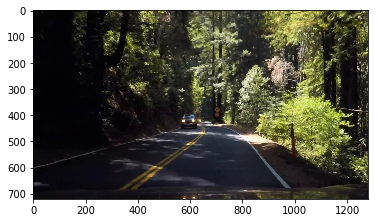

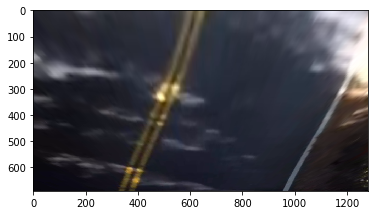

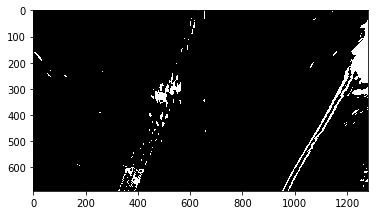

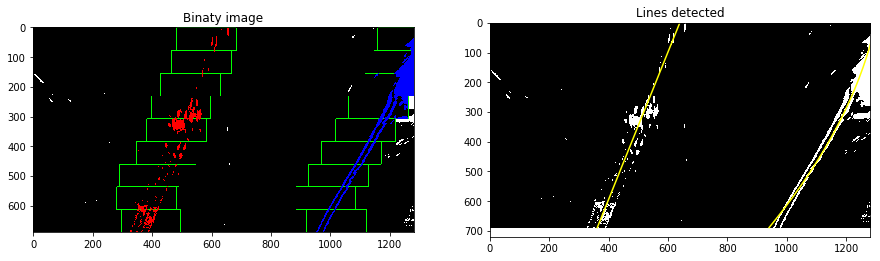

80942.1806451 383.978216421
True


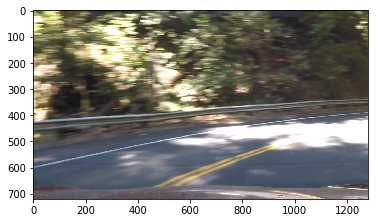

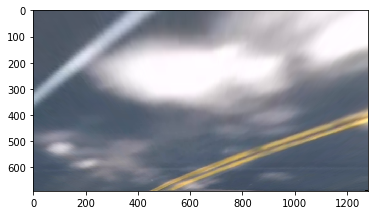

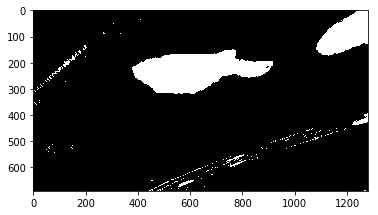

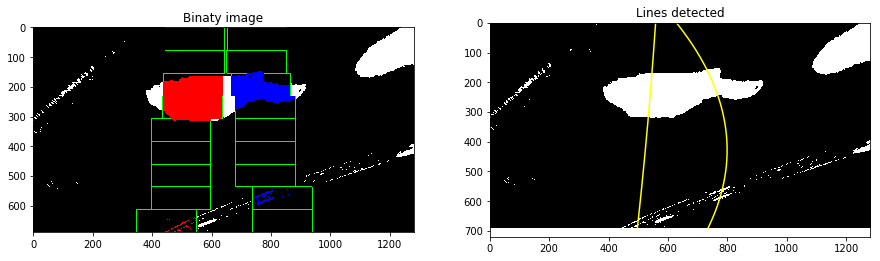

5446.38414923 177.430269803
here [  9.00748801e-04   8.64609444e-01   7.01356501e+01]
False


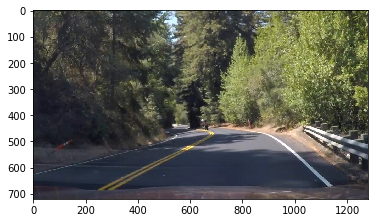

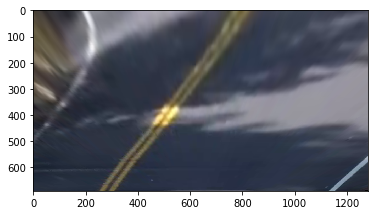

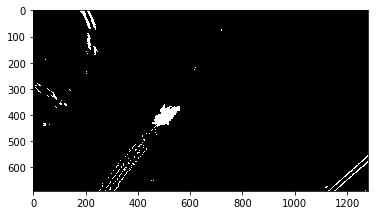

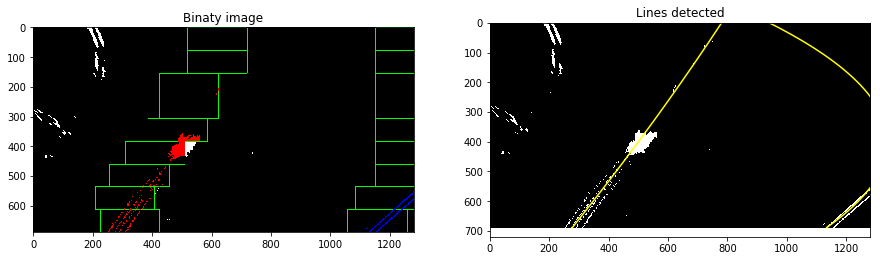

1602.00447202 69.7705295626
here [  2.36632635e-03   2.63984988e+00   1.60207850e+02]
False


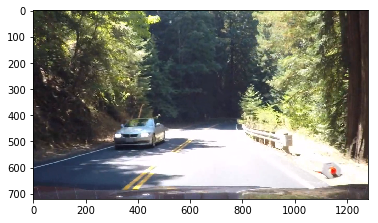

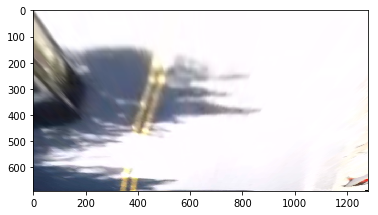

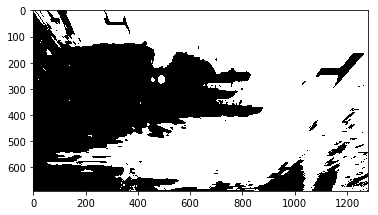

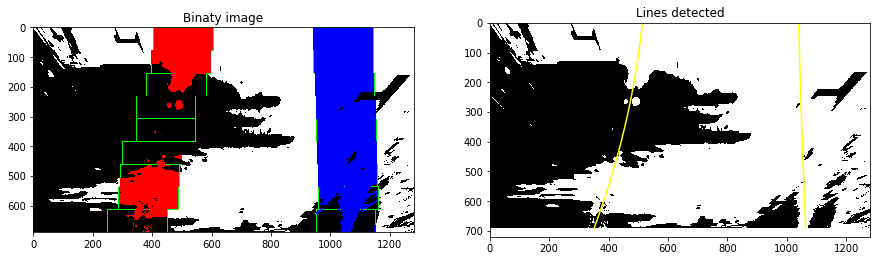

850.561946072 13679.6216042
True


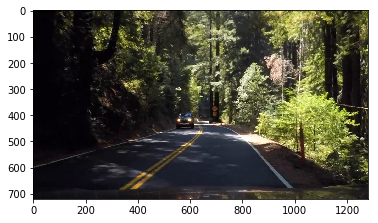

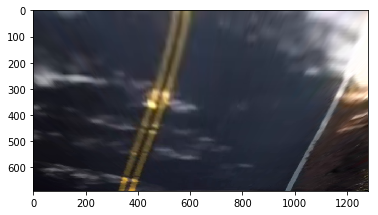

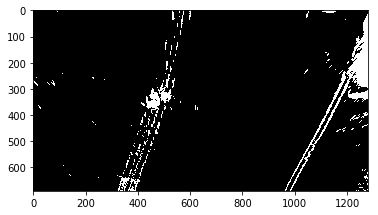

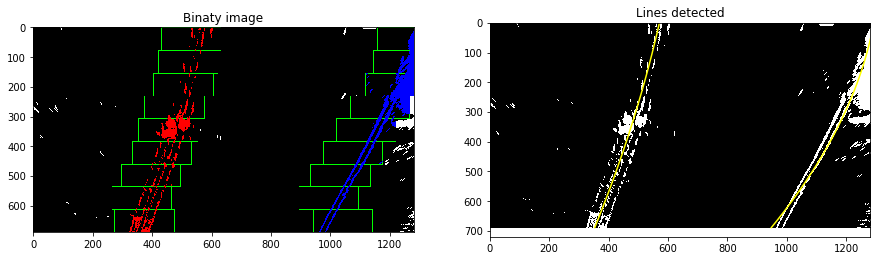

1272.66508591 361.947278573
True


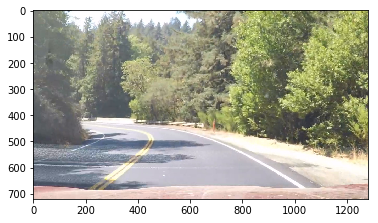

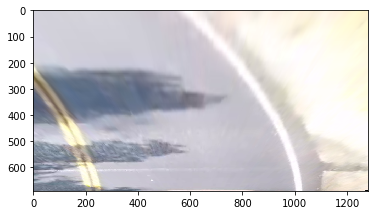

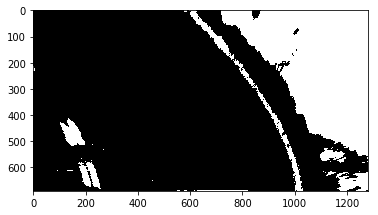

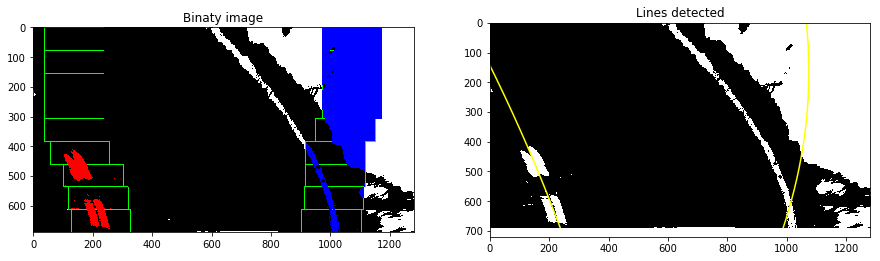

1491.87533352 525.362841795
True


In [210]:
from random import shuffle

#shuffle(errors)

for a in errors[:6]:
    img=a[0]
    image=undistort(img)
    plt.imshow(img)
    plt.show()
    
    
    prj=pr(image)
    plt.imshow(prj)
    plt.show()
    
    bina=add_f[0](prj,**add_f[1])
    
    plt.imshow(bina,cmap='gray')
    plt.show()
    
    try:
        l1,l2,r1,r2=fit_poly(bina, verbose=True)
        print (r1,r2)
        res=check_lines((l1,l2))
    except:
        res=False
    
    print(res )

In [ ]:
l

In [36]:
div=np.abs(lines[0]-lines[1])
if div[0]<0.0005 and div[1]<0.7 and div[2]>600 and div[2]<950:
    print ('bad')

In [38]:
np.abs(div).tolist()

[8.171007647461377e-05, 0.42323647776232476, 474.4734484433318]

In [41]:
lines=np.array(lines)
lines[:,0]*690**2+lines[:,1]*690+lines[:,2]

array([  324.29716637,  1051.90161706])

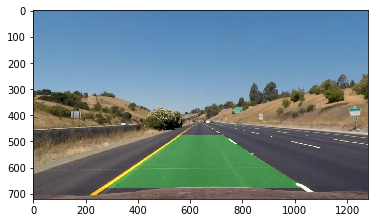

13093.8668145 13200.8649994


In [55]:
img=images[0]

l=Line()
plt.imshow(l.process_img(img))
plt.show()

left_fit, right_fit=l.best_fit

y_eval = warped.shape[0]
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

In [56]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

NameError: name 'leftx' is not defined

In [65]:
image.shape

(720, 1280, 3)

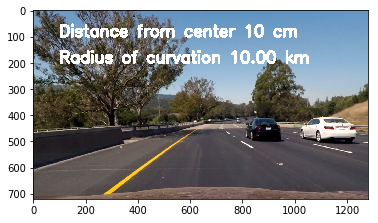

In [91]:
imagecp=np.copy(image)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(imagecp,'Distance from center %d cm' % 10,(100,100), font, 2,(255,255,255),10)
cv2.putText(imagecp,'Radius of curvation %.2f km' % 10,(100,200), font, 2,(255,255,255),10)

        
plt.imshow(imagecp)
plt.show()
        